### VaR Comparison

In [343]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from scipy.stats import norm
import matplotlib.pyplot as plt

import seaborn as sns


#### Fetching stock data

In [344]:
stock_df = pd.read_csv('data/stock_data.csv')

In [345]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc=True)
stock_df['Date'] = stock_df['Date'].dt.date
stock_df['Date'] = stock_df['Date'].apply(lambda x: dt.datetime.combine(x, dt.time(0, 0)))

In [346]:
def convert_csv_df_to_yf_df(csv_df):
    """Convert a CSV DataFrame to a format similar to Yahoo Finance DataFrame.
    The CSV DataFrame should have 'Date', 'Ticker', 'Open', 'High', 'Low', 'Close', and 'Volume' columns.
    """    

    # Ensure the Date column is of datetime type.
    csv_df['Date'] = pd.to_datetime(csv_df['Date'])

    # Define the price columns that you want to keep.
    price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Pivot the DataFrame.
    # With a list for values, pivot_table creates a MultiIndex on the columns where the first level is the price fields
    # and the second level is the ticker symbol.
    multi_df = csv_df.pivot_table(index='Date', columns='Ticker', values=price_cols)

    # Optionally, sort the MultiIndex columns.
    multi_df = multi_df.sort_index(axis=1)

    # Set the MultiIndex column names so that the first level is 'Price' and the second is 'Ticker'.
    multi_df.columns.names = ['Price', 'Ticker']

    return multi_df


#### Declaring classes

##### Portofolio Class

In [347]:

class PortofolioData:
    def __init__(self, stocks, weights, Time, initial_investment, forecast_start_date=dt.datetime.now(), yahoo_finance=False):
        self.stocks = stocks
        self.weights = np.array(weights)
        self.Time = Time  # number of days over which the var is calculated
        self.initial_investment = initial_investment
        self.returns, self.mean_returns, self.cov_matrix = self.get_data(
                start_date=forecast_start_date-dt.timedelta(days=800), end_date=forecast_start_date, yahoo_finance=yahoo_finance)

    def get_data(
        self,
        start_date=dt.datetime.now() - dt.timedelta(days=800),
        end_date=dt.datetime.now(),
        yahoo_finance=False,
    ):
        # Get historical data and calculate returns
        if yahoo_finance:
            stock_data = yf.download(self.stocks, start=start_date, end=end_date)
        else:
            stock_data = stock_df[(stock_df['Ticker'].isin(self.stocks)) & (stock_df['Date'] >= start_date) & (stock_df['Date'] <= end_date)]
            stock_data = convert_csv_df_to_yf_df(stock_data)
        stock_data = stock_data["Close"]
        returns = stock_data.pct_change()
        mean_returns = returns.mean()
        cov_matrix = returns.cov()
        returns = returns.dropna()
        returns["portofolio"] = returns.dot(self.weights)
        return returns, mean_returns, cov_matrix

    def get_expected_portofolio_performance(self):
        expected_returns = np.sum(self.mean_returns * self.weights) * self.Time
        expected_std = np.sqrt(
            np.dot(self.weights.T, np.dot(self.cov_matrix, self.weights))
        ) * np.sqrt(self.Time)
        return expected_returns, expected_std

    def __str__(self):
        txt = ""
        txt += f"PORTOFOLIO: {self.initial_investment}\n"
        for i in range(len(self.stocks)):
            txt += f"{self.stocks[i]}:{self.weights[i]*100}%\n"
        txt += "--------------------------\n"
        txt += "Returns:\n"
        txt += f"{self.returns}\n"
        txt += "--------------------------\n"
        txt += "Mean Returns:\n"
        txt += f"{self.mean_returns}\n"
        txt += "--------------------------\n"
        txt += "Covariance Matrix\n"
        txt += f"{self.cov_matrix}\n"
        txt += "--------------------------\n"
        return txt


##### VaR Class

In [348]:

class VaR:
    def __init__(self, portofolio: PortofolioData, confidence_level=0.95):
        self.portofolio = portofolio
        self.confidence_level = confidence_level
        self.alpha = 1 - confidence_level

    def calculate_historical_var(self):
        h_var = -np.percentile(
            self.portofolio.returns["portofolio"], self.alpha * 100
        ) * np.sqrt(self.portofolio.Time)

        return {
            "relative": h_var,
            "absolute": self.portofolio.initial_investment * h_var,
        }

    def calculate_parametric_var(self):

        expected_portofolio_return, expected_portofolio_std = (
            self.portofolio.get_expected_portofolio_performance()
        )

        p_var = (
            norm.ppf(self.confidence_level) * expected_portofolio_std
            - expected_portofolio_return
        )

        return {
            "relative": p_var,
            "absolute": self.portofolio.initial_investment * p_var,
        }

    def calculate_monte_carlo_var(self, simulations=1000):
        mean_m = np.full(
            shape=(self.portofolio.Time, len(self.portofolio.weights)),
            fill_value=self.portofolio.mean_returns,
        )
        mean_m = mean_m.T

        portfolio_sims = np.full(
            shape=(self.portofolio.Time, simulations), fill_value=0.0
        )

        for m in range(0, simulations):
            Z = np.random.normal(
                size=(self.portofolio.Time, len(self.portofolio.weights))
            )
            L = np.linalg.cholesky(self.portofolio.cov_matrix)
            daily_returns = mean_m + np.inner(L, Z)
            portfolio_sims[:, m] = (
                np.cumprod(np.inner(self.portofolio.weights, daily_returns.T) + 1)
                * self.portofolio.initial_investment
            )

        portResults = pd.Series(portfolio_sims[-1, :])
        kept = np.percentile(portResults, self.alpha * 100)

        absolute_mc_var = self.portofolio.initial_investment - kept
        relative_mc_var = absolute_mc_var / self.portofolio.initial_investment

        return {
            "relative": relative_mc_var,
            "absolute": absolute_mc_var,
        }

    def __str__(self):
        historical_var = self.calculate_historical_var()
        parametric_var = self.calculate_parametric_var()
        monte_carlo_var = self.calculate_monte_carlo_var()

        txt = "Value at Risk (VaR) Analysis:\n"
        txt += f"Confidence Level: {self.confidence_level * 100}%\n"
        txt += f"Historical VaR: {historical_var}\n"
        txt += f"Parametric VaR: {parametric_var}\n"
        txt += f"Monte Carlo VaR: {monte_carlo_var}\n"
        return txt


##### Fetching test portofolios

In [349]:
from generate_random_portfolios import read_portfolios_from_json

test_portfolios = read_portfolios_from_json("data/random_portfolios.json")

In [350]:
tp = test_portfolios[0]
stocks = tp["stocks_list"]
weights = tp["stocks_weights"]
initial_investment = tp['initial_investment']
end_date = dt.datetime.strptime(tp["start_date"], "%Y-%m-%d")
start_date = end_date - dt.timedelta(days=800)


stock_data = stock_df[(stock_df['Ticker'].isin(stocks)) & (stock_df['Date'] >= start_date) & (stock_df['Date'] <= end_date)]
stock_data = convert_csv_df_to_yf_df(stock_data)

C:\Users\mario\AppData\Local\Temp\ipykernel_19084\132587994.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv_df['Date'] = pd.to_datetime(csv_df['Date'])


In [351]:
stock_data.head()

Price            Close                               High             \
Ticker              MA       PINS         TGT          MA       PINS   
Date                                                                   
2022-07-11  322.171326  18.510000  141.491272  324.188684  19.959999   
2022-07-12  320.849579  18.500000  139.722504  325.321558  19.180000   
2022-07-13  321.356415  18.410000  140.573044  322.906698  18.840000   
2022-07-14  323.006073  17.559999  141.394577  325.540182  18.379999   
2022-07-15  330.499115  20.400000  141.761871  333.480434  20.780001   

Price                          Low                               Open  \
Ticker             TGT          MA       PINS         TGT          MA   
Date                                                                    
2022-07-11  143.733644  317.162700  18.420000  140.911344  317.391279   
2022-07-12  144.651845  318.216086  18.370001  138.794637  318.216086   
2022-07-13  142.399797  311.855946  17.709999  137.470456  313.982635   
2022-07-14  141.645886  313.426116  17.320000  138.137355  314.191310   
2022-07-15  143.704604  327.706615  19.629999  140.969319  331.552512   

Price                                 Volume                         
Ticker           PINS         TGT         MA        PINS        TGT  
Date                                                                 
2022-07-11  19.820000  143.037736  2073800.0  12650100.0  2050800.0  
2022-07-12  18.719999  141.752236  2761500.0  13235600.0  3132800.0  
2022-07-13  17.980000  137.886074  2442600.0   9182500.0  2769000.0  
2022-07-14  18.250000  138.736602  2743900.0  16285700.0  2976000.0  
2022-07-15  19.930000  142.970042  3387400.0  42856000.0  3831500.0

In [352]:

yf_data = yf.download(stocks, start=start_date, end=end_date)

[*********************100%***********************]  3 of 3 completed


#### Comparing the VaR methods

In [353]:
# Get returns for each portofolio
returns = []
portofolios = []

for test_portfolio in test_portfolios:

    test_portfolio["start_date"] = dt.datetime.strptime(test_portfolio["start_date"], "%Y-%m-%d")

    portofolio = PortofolioData(
        stocks=test_portfolio["stocks_list"],
        weights=test_portfolio["stocks_weights"],
        Time=test_portfolio["time"],
        initial_investment=test_portfolio["initial_investment"],
        forecast_start_date=  test_portfolio["start_date"],
        yahoo_finance=False,
    )
    portofolios.append(portofolio)
    

    ret, mean_ret, cov_matrix = portofolio.get_data(
        test_portfolio["start_date"], 
        test_portfolio["start_date"] + dt.timedelta(days=test_portfolio["time"])
    )

    returns.append(ret)


C:\Users\mario\AppData\Local\Temp\ipykernel_19084\132587994.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv_df['Date'] = pd.to_datetime(csv_df['Date'])
C:\Users\mario\AppData\Local\Temp\ipykernel_19084\132587994.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csv_df['Date'] = pd.to_datetime(csv_df['Date'])
C:\Users\mario\AppData\Local\Temp\ipykernel_19084\132587994.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [354]:

def show_portfolio_distribution(returns, quantile = 0.05):
    sns.histplot(returns, bins=30, kde=True)

    quantile_mark = returns.quantile(quantile)  
    plt.axvline(quantile_mark, color='red', linestyle='dashed', label=f'95% Quantile: {quantile_mark:.4f}')

    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Return Distribution')
    plt.legend()
    plt.show()

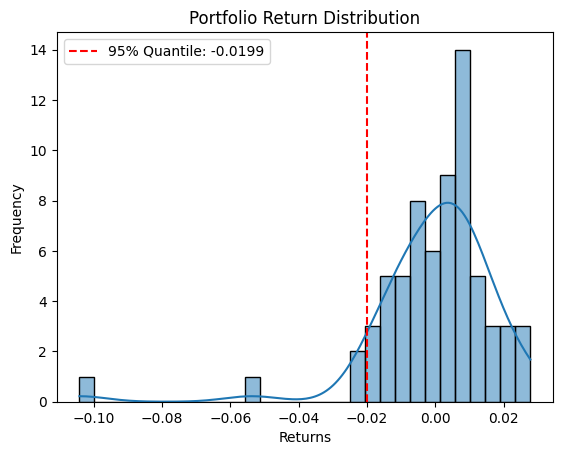

In [355]:
show_portfolio_distribution(returns[0]['portofolio'])

In [356]:
values_at_risk = []
for portofolio in portofolios:
    try:
        var = VaR(portofolio, confidence_level=0.95)

        values_at_risk.append(
            {
                "historical": -var.calculate_historical_var()['relative'],
                "parametric": -var.calculate_parametric_var()['relative'],
                "monte_carlo": -var.calculate_monte_carlo_var()['relative'],
            }
        )
    except:
        print('VaR could not be calculated')

In [357]:


def show_portfolio_distribution_with_vars(returns, var_dict, quantile=0.05):
    # Plot the distribution with histogram and KDE
    sns.histplot(returns, bins=50, kde=True)
    
    # Plot the base quantile (for reference)
    base_quantile = returns.quantile(quantile)
    plt.axvline(base_quantile, color='black', 
                label=f'{quantile*100:.0f}% Quantile of Returns: {base_quantile:.4f}')
    
    # Define a unique color for each VaR method
    colors = {
        "historical": "red",
        "parametric": "blue",
        "monte_carlo": "green"
    }
    
    # Plot a vertical line for each VaR method
    for method, var_value in var_dict.items():
        plt.axvline(var_value, color=colors.get(method, "gray"), linestyle='dashed', 
                    label=f'{method.capitalize()} VaR: {var_value:.4f}')
    
    # Determine the range to zoom in on the vertical lines
    # Get minimum and maximum of base quantile and all VaR values
    values = [base_quantile] + list(var_dict.values())
    min_val, max_val = min(values), max(values)
    
    # Calculate margin: you can adjust this multiplier to zoom in/out as desired
    margin = (max_val - min_val) * 0.5  
    plt.xlim(min_val - margin, max_val + margin)
    
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Return Distribution with VaR Estimates')
    plt.legend()
    plt.show()



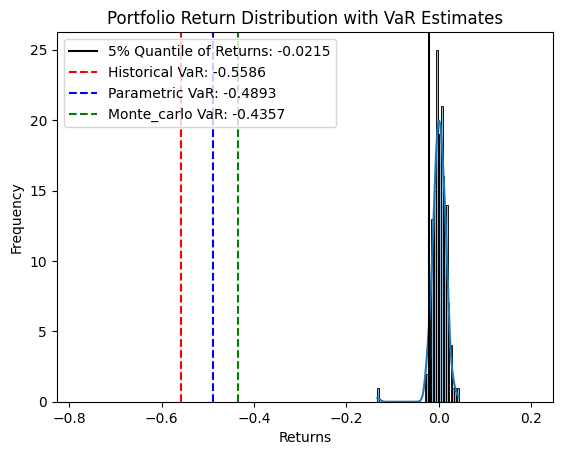

In [372]:
min_index = 24
show_portfolio_distribution_with_vars(returns[min_index]['portofolio'], values_at_risk[min_index], quantile=0.05)

##### RMSE

For our chosen way of comparing the models, we will pick the root square mean deviation (RMSE).

In [359]:
def rmse_of_quantiles(VaR, actual_losses):
    return np.sqrt(np.mean((VaR - actual_losses) ** 2))

In [360]:
rmses = []

for i in range(len(values_at_risk)):
    actual_losses = returns[i]['portofolio'].quantile(0.95)
    historical_var = values_at_risk[i]['historical']
    parametric_var = values_at_risk[i]['parametric']
    monte_carlo_var = values_at_risk[i]['monte_carlo']

    rmses.append(
        {
            "historical": rmse_of_quantiles(historical_var, actual_losses),
            "parametric": rmse_of_quantiles(parametric_var, actual_losses),
            "monte_carlo": rmse_of_quantiles(monte_carlo_var, actual_losses),
        }
    )

In [361]:
returns[0]['portofolio'].quantile(0.05)

np.float64(-0.01994565128568339)

In [362]:
values_at_risk[0]['historical']

np.float64(-0.22895902709529012)

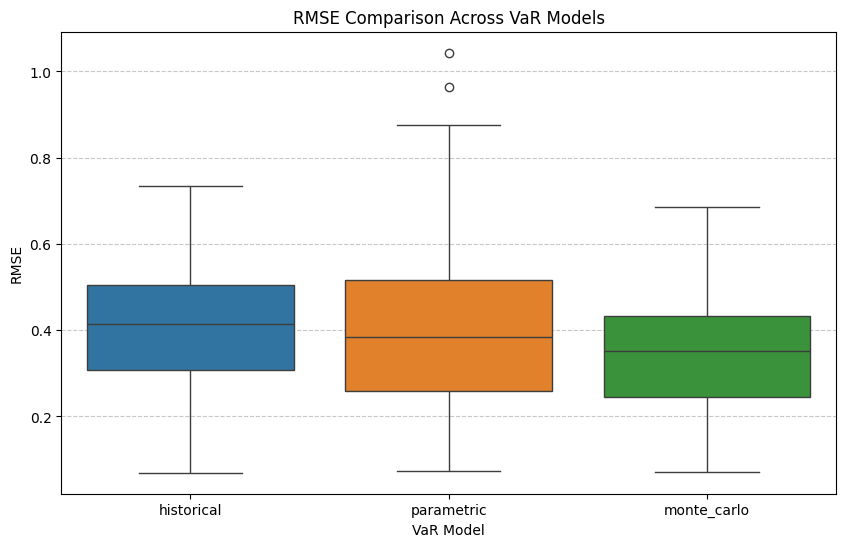

In [363]:
rmse_df = pd.DataFrame(rmses)

# Plot the RMSE values
plt.figure(figsize=(10, 6))
sns.boxplot(data=rmse_df)

plt.title("RMSE Comparison Across VaR Models")
plt.ylabel("RMSE")
plt.xlabel("VaR Model")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [364]:
len(rmse_df)

100

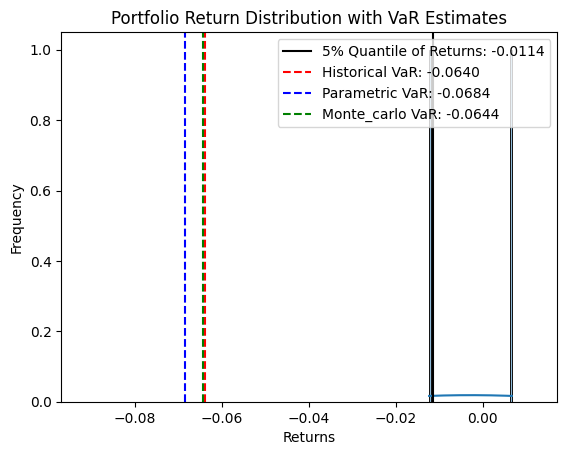

In [365]:
min_index = rmse_df['historical'].idxmin()
show_portfolio_distribution_with_vars(returns[min_index]['portofolio'], values_at_risk[min_index], quantile=0.05)

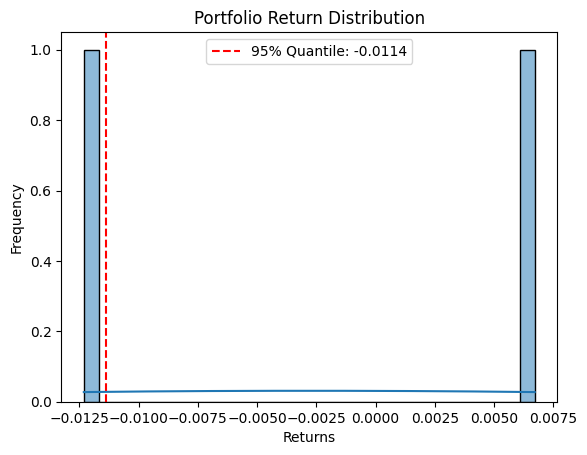

In [366]:
show_portfolio_distribution(returns[min_index]['portofolio'], quantile=0.05)

In [367]:
test_portfolios[min_index]

{'stocks_list': ['NVDA', 'ZM', 'SHOP', 'BAMXF', 'TGT', 'MSFT', 'COST'],
 'stocks_weights': [0.066, 0.267, 0.191, 0.141, 0.124, 0.071, 0.14],
 'initial_investment': 58381.26,
 'time': 4,
 'start_date': datetime.datetime(2023, 11, 30, 0, 0)}

In [368]:
rmse_df.describe()

,historical,parametric,monte_carlo
count,100.000000,100.000000,100.000000
mean,0.405082,0.403348,0.347938
std,0.145635,0.186420,0.128447
min,0.069737,0.074168,0.070154
25%,0.307432,0.259672,0.245675
50%,0.414055,0.385193,0.351440
75%,0.503711,0.516243,0.432987
max,0.735066,1.043449,0.684813


### Custom VaR Model

In [369]:
data = yf.download(
    ["AAPL",], start="2020-01-01", end="2023-10-01"
)
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.716072,72.776598,71.466812,71.721019,135480400
2020-01-03,72.009117,72.771745,71.783962,71.941328,146322800
2020-01-06,72.582909,72.621646,70.876075,71.127866,118387200
2020-01-07,72.241539,72.849216,72.021223,72.592586,108872000
2020-01-08,73.403633,73.706264,71.943744,71.943744,132079200
...,...,...,...,...,...
2023-09-25,174.798859,175.682382,172.882893,172.932533,46172700
2023-09-26,170.708817,173.925232,170.410996,173.548008,64588900


In [370]:
data.Close['AAPL'].index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2023-09-18', '2023-09-19', '2023-09-20', '2023-09-21',
               '2023-09-22', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29'],
              dtype='datetime64[ns]', name='Date', length=943, freq=None)